In [14]:
import os
import sys

# Get the parent directory of the current working directory
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to PYTHONPATH if it's not already there
if parent_path not in sys.path:
    sys.path.insert(0, parent_path)

# Optionally verify
print("Parent directory added to PYTHONPATH:", parent_path)
print("Current PYTHONPATH:", sys.path)

from src.models.nnc2p import NNC2P
from src.utils.helpers import get_device
from src.training.train import get_model
from src.utils.arg_parser import parse_args_and_config
from src.data.data_generator import HybridPiecewiseDataGenerator, TabulatedDataGenerator, HybridPiecewiseDataGenerator_3D

import torch
import torch.nn as nn

import numpy as np


Parent directory added to PYTHONPATH: /home/astro/miler/codes/c2p_ML
Current PYTHONPATH: ['/home/astro/miler/codes/c2p_ML', '/home/astro/miler/.pyenv/versions/3.10.15/lib/python310.zip', '/home/astro/miler/.pyenv/versions/3.10.15/lib/python3.10', '/home/astro/miler/.pyenv/versions/3.10.15/lib/python3.10/lib-dynload', '', '/scratch/astro/miler/python-env/pytorch/lib/python3.10/site-packages']


A config file for experimenting with it

In [8]:
device = get_device()
config = {
    "model": {
        "name": "NNC2PS",
        "input_dim": 3,
        "hidden_dims": [600, 200],
        "output_dim": 1
    },
    "training": {
        "batch_size": 32,
        "num_epochs": 85,
        "learning_rate": 3e-4,
        "penalty_factor": 150.0,
        "validation_split": 0.05,
        "test_split": 0.05
    },
    "data": {
        "n_samples": 500000,
        "gamma_th": 1.666667,  # 5/3
        "rho_min": 2.0e-5,
        "rho_max": 2.0e-3,
        "vx_max": 0.721,
        "eps_min": 0,
        "eps_max": 2,
        "K": [8.9493e-02, None, None, None],
        "Gamma": [1.3569, 3.0050, 2.9880, 2.8510],
        "rho_breaks": [2.3674e-04, 8.1147e-04, 1.6191e-03]
    },
    "paths": {
        "models": "models",
        "images": "images",
        "eos_tables": "eos_tables"
    }
}
model = NNC2P(config).to(device)

Getting the right data for comparison

In [11]:
def get_data_generator(config):
    model_name = config["model"]["name"]
    if model_name in ["NNC2PS", "NNC2PL"]:
        return HybridPiecewiseDataGenerator(config)
    elif model_name == "NNC2P_Tabulated":
        return TabulatedDataGenerator(config)
    elif model_name in ["NNC2PS_3D"]:
        return HybridPiecewiseDataGenerator_3D(config)
    else:
        raise ValueError(f"Unknown model type for data generation: {model_name}")
# Ensure required directories exist
device = get_device()
model = get_model(config)
data_generator = get_data_generator(config)
train_loader, val_loader, test_loader = data_generator.get_data_loaders()


Now I want to check on how I can transform my data back to its otiginal Size for comparison.

Copy and Paste it later

In [16]:
# Print dataset size
print(f"Train size: {len(train_loader.dataset)}")

# Access and convert the first sample for demonstration
first_sample_input, first_sample_target = train_loader.dataset[0]

# Ensure data is in NumPy format for transformation
first_sample_input_numpy = first_sample_input.numpy()
first_sample_target_numpy = first_sample_target.numpy()

print(f"Train input values (first sample): {first_sample_input_numpy}")
print(f"Train target values (first sample): {first_sample_target_numpy}")

# Perform inverse transformation
train_input_original = data_generator.input_scaler.inverse_transform(
    first_sample_input_numpy.reshape(1, -1)
)
train_target_original = data_generator.output_scaler.inverse_transform(
    first_sample_target_numpy.reshape(1, -1)
)

print("Original (inverse transformed) values:")
print(f"Input: {train_input_original}")
print(f"Target: {train_target_original}")


# Now for the entire Dataset

# Extract entire dataset from train_loader
inputs_numpy = np.array([data[0].numpy() for data in train_loader.dataset])
targets_numpy = np.array([data[1].numpy() for data in train_loader.dataset])

# Inverse transform the entire dataset
inputs_original = data_generator.input_scaler.inverse_transform(inputs_numpy)
targets_original = data_generator.output_scaler.inverse_transform(targets_numpy)

print("Original values (entire dataset):")
print(f"Inputs: {inputs_original}")
print(f"Targets: {targets_original}")

Train size: 450000
Train input values (first sample): [-0.3143256  -0.45664564 -0.6378817 ]
Train target values (first sample): [-0.67324185]
Original (inverse transformed) values:
Input: [[0.00092353 0.00069127 0.00067814]]
Target: [[0.00035821]]
Original values (entire dataset):
Inputs: [[9.2353229e-04 6.9126644e-04 6.7813741e-04]
 [2.7608022e-04 4.3215303e-04 5.5569189e-04]
 [4.6356628e-04 1.1825754e-03 1.1077364e-03]
 ...
 [6.6315918e-04 7.0763129e-04 1.1980104e-03]
 [1.6341013e-03 5.5660417e-05 1.0971789e-03]
 [1.3795689e-03 8.3031465e-04 1.9615456e-03]]
Targets: [[0.00035821]
 [0.00027143]
 [0.000312  ]
 ...
 [0.00069499]
 [0.00095413]
 [0.00134996]]


In [36]:
weights = torch.jit.load("../models/NNC2PS.pth")
#model.load_state_dict(weights)
weights(torch.tensor([1.0, 1.0, 1.0], device=device))
print(model)

NNC2P(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)


In [52]:
import torch

# Configuration
n_samples = 1000000  # Number of samples
v_max = torch.tensor(0.721)

# Compute corresponding velocity magnitudes
v_magnitudes = torch.rand(n_samples) * v_max

# Generate random directions on the unit sphere
phi = 2 * torch.pi * torch.rand(n_samples)           # Azimuthal angle
theta = torch.pi * torch.rand(n_samples)           # Cosine of polar angle

# Compute velocity components
vx = v_magnitudes * torch.sin(theta) * torch.cos(phi)
vy = v_magnitudes * torch.sin(theta) * torch.sin(phi)
vz = v_magnitudes * torch.cos(theta)

# Stack into a single tensor
velocities = torch.stack((vx, vy, vz), dim=1)

print(velocities.shape)  # Should be (n_samples, 3)


torch.Size([1000000, 3])


In [53]:
for i in range(10000):
    print(velocities[i][0]**2 + velocities[i][1]**2 + velocities[i][2]**2)

tensor(0.3369)
tensor(0.4884)
tensor(0.0695)
tensor(0.0239)
tensor(0.0897)
tensor(0.0612)
tensor(0.1817)
tensor(0.2435)
tensor(0.1241)
tensor(0.0083)
tensor(0.1722)
tensor(0.2973)
tensor(0.0362)
tensor(0.0067)
tensor(0.0239)
tensor(0.0070)
tensor(0.0644)
tensor(0.1690)
tensor(0.5122)
tensor(0.3776)
tensor(0.2036)
tensor(0.3313)
tensor(0.0078)
tensor(0.0763)
tensor(0.0342)
tensor(0.5117)
tensor(0.3329)
tensor(0.3478)
tensor(0.0943)
tensor(0.1566)
tensor(0.2232)
tensor(0.0086)
tensor(0.1775)
tensor(0.1773)
tensor(0.3306)
tensor(0.3713)
tensor(0.1770)
tensor(0.0379)
tensor(0.0178)
tensor(0.1392)
tensor(0.2445)
tensor(0.0145)
tensor(0.3121)
tensor(0.1383)
tensor(0.0723)
tensor(0.3267)
tensor(0.0827)
tensor(0.1172)
tensor(0.0019)
tensor(0.2611)
tensor(0.2391)
tensor(0.4596)
tensor(0.2981)
tensor(0.1187)
tensor(0.1869)
tensor(0.0508)
tensor(0.1382)
tensor(0.0956)
tensor(0.0992)
tensor(0.3704)
tensor(0.2336)
tensor(0.1912)
tensor(0.0766)
tensor(0.0516)
tensor(9.0664e-06)
tensor(0.2884)
tensor

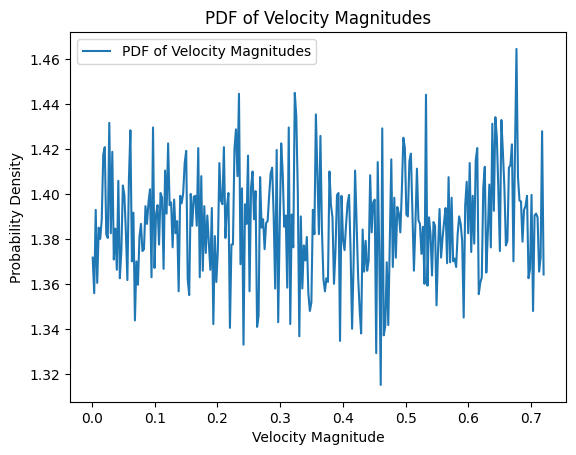

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming velocities is already a NumPy array (or convert from PyTorch)
velocities_np = velocities.cpu().numpy()

# Calculate the magnitude of velocities
velocity_magnitudes = np.sqrt(
    velocities_np[:, 0]**2 + velocities_np[:, 1]**2 + velocities_np[:, 2]**2
)

# Create a histogram to approximate the PDF
bins = 300  # Number of bins for the histogram
hist, bin_edges = np.histogram(velocity_magnitudes, bins=bins, density=True)

# Calculate the bin centers
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Plot the PDF
plt.plot(bin_centers, hist, label="PDF of Velocity Magnitudes")
plt.xlabel("Velocity Magnitude")
plt.ylabel("Probability Density")
plt.title("PDF of Velocity Magnitudes")
plt.legend()
plt.show()
